**1. Aktivasi Kaggle dengan API yang telah disediakan**

In [3]:
! chmod 600 /content/kaggle.json

**2. Download dataset dari Kaggle**

In [4]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d alfanme/indonesian-batik-motifs-corak-app

 92% 143M/156M [00:01<00:00, 93.8MB/s]
100% 156M/156M [00:01<00:00, 92.5MB/s]


**3. Buat folder baru untuk menjadi direktori file hasil ekstraksi dataset**

In [5]:
!mkdir /content/Batik 

**4. Extract zip file dataset yang telah didownload**

In [6]:
import zipfile
zip_file = zipfile.ZipFile('/content/indonesian-batik-motifs-corak-app.zip')
zip_file.extractall('/content/Batik')

**5. Tahap Preprocessing menggunakan library Image Data Generator**

**6. Lakukan augmentasi data train untuk memperbanyak dataset yang sedikit**

**7. Define data train dengan menggunakan flow from directory agar setiap dataset diberikan label secara otomatis**

In [7]:
# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#augmentasi data agar dataset lebih bervariasi
train_gen = ImageDataGenerator(rescale=1/255,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rotation_range=60,
                               zoom_range=0.3,
                               fill_mode='nearest')
#membuat data train dengan menggunakan flow from directory
train_data = train_gen.flow_from_directory('/content/Batik/DATASETv7/TRAIN',
                                                 target_size = (224,224),
                                                 batch_size = 105,
                                                 class_mode = 'categorical')

Found 1050 images belonging to 15 classes.


In [8]:
val_gen = ImageDataGenerator(rescale=1/255)
val_data = val_gen.flow_from_directory('/content/Batik/DATASETv7/TEST',
                                       target_size = (224,224),
                                       batch_size = 30,
                                       class_mode = 'categorical')

Found 300 images belonging to 15 classes.


In [9]:
test_gen = ImageDataGenerator(rescale=1/255)
test_data = test_gen.flow_from_directory('/content/Batik/DATASETmin/DATASETmin/TEST',
                                       target_size = (224,224),
                                       batch_size = 20,
                                       class_mode = 'categorical')

Found 200 images belonging to 10 classes.


In [23]:
#Konstruksi Model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#konstruksi menggunakan 15 layer
cnn_model = Sequential([Conv2D(16,(3,3), activation='relu', input_shape=(224,224,3)),
                        Conv2D(16,(3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Dropout(rate=0.2),
                        Conv2D(32,(3,3), activation='relu'),
                        Conv2D(32,(3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Dropout(rate=0.2),
                        Conv2D(64,(3,3), activation='relu'),
                        Conv2D(64,(3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Dropout(rate=0.2),
                        Flatten(),
                        Dropout(rate=0.2),
                        Dense(128, activation='relu'),
                        Dropout(rate=0.2),
                        Dense(15, activation='softmax')])   #dense 15 unit karena memiliki 15 class
                                                            #activation softmax untuk multiclass classification

In [27]:
#Konstruksi Model 2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from glob import glob

IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in inception.layers:
  layer.trainable = False 
folders = glob('/content/Batik/DATASETv7/TRAIN/*')

x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)
cnn_model = Model(inputs=inception.input, outputs=prediction)

87924736/87910968 [==============================] - 1s 0us/step


In [28]:
#Compile Model
cnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_45 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 111, 111, 32  96         ['conv2d_45[0][0]']              
 ormalization)                  )                                                             

In [29]:
#Training Model
history = cnn_model.fit(train_data,
                    steps_per_epoch = 10,           #jumlah train data/batchsize = 1050/105
                    epochs = 50,
                    validation_data = val_data,
                    validation_steps = 10,          #jumlah validasi data/batchsize = 300/30
                    verbose = 2)

Epoch 1/50
10/10 - 27s - loss: 28.5097 - accuracy: 0.0962 - val_loss: 30.3526 - val_accuracy: 0.1933 - 27s/epoch - 3s/step
Epoch 2/50
10/10 - 16s - loss: 26.4966 - accuracy: 0.2248 - val_loss: 10.5966 - val_accuracy: 0.2933 - 16s/epoch - 2s/step
Epoch 3/50
10/10 - 16s - loss: 10.0735 - accuracy: 0.4000 - val_loss: 8.0899 - val_accuracy: 0.4367 - 16s/epoch - 2s/step
Epoch 4/50
10/10 - 16s - loss: 6.0581 - accuracy: 0.5019 - val_loss: 4.9155 - val_accuracy: 0.5033 - 16s/epoch - 2s/step
Epoch 5/50
10/10 - 16s - loss: 3.3339 - accuracy: 0.5886 - val_loss: 3.4999 - val_accuracy: 0.5567 - 16s/epoch - 2s/step
Epoch 6/50
10/10 - 16s - loss: 2.5083 - accuracy: 0.6533 - val_loss: 3.1856 - val_accuracy: 0.5333 - 16s/epoch - 2s/step
Epoch 7/50
10/10 - 16s - loss: 1.5664 - accuracy: 0.7010 - val_loss: 2.3948 - val_accuracy: 0.5900 - 16s/epoch - 2s/step
Epoch 8/50
10/10 - 16s - loss: 1.4496 - accuracy: 0.7114 - val_loss: 2.2849 - val_accuracy: 0.6133 - 16s/epoch - 2s/step
Epoch 9/50
10/10 - 16s - lo

In [30]:
eval = cnn_model.evaluate(val_data)
print(f'Accuracy = {eval[1]}')

10/10 [==============================] - 2s 167ms/step - loss: 2.2196 - accuracy: 0.6400
Accuracy = 0.6399999856948853


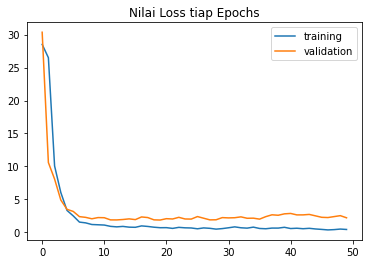

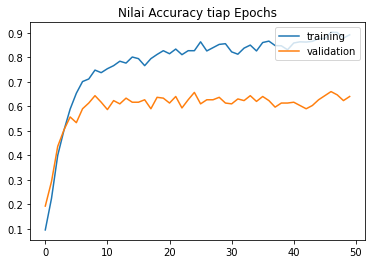

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Nilai Loss tiap Epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Nilai Accuracy tiap Epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [32]:
cnn_model.save('Batik.h5')

In [40]:
import cv2
from tensorflow import keras
from PIL import Image
import numpy as np

model_path = 'Batik.h5'
loaded_model = keras.models.load_model(model_path)

test_image = '/content/Batik/DATASETv7/TEST/Batik Parang/71.jpg'
image = cv2.imread(test_image)

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224,224))
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
hasil = train_data.class_indices
key_list = list(hasil)
prediksi = key_list[result]
print(f'Hasil Prediksi adalah {prediksi}')

Hasil Prediksi adalah Batik Parang
